# Dog Breed Identification: Machine Learning from Kaggle Competition

My name is André Fernandes and in this notebook is presented my solution proposal for the competition. Feel free to connect with me on LinkedIn and check out my other projects on GitHub:

[LinkedIn](https://www.linkedin.com)
[GitHub](https://www.linkedin.com/in/andr%C3%A9-fernandes-868006207/)

Below is the description of the competition and the link to the main page if you want to check it for yourself.

**Competition Description**

The Dog Breed Identification competition challenges participants to identify the breed of a dog in an image. This notebook will guide you through the process of building a predictive model that classifies dog breeds based on image data.

This competition is hosted on Kaggle: [Dog Breed Identification](https://www.kaggle.com/competitions/dog-breed-identification/overview)

## Table of Contents

1. Introduction
2. Data Description
3. Exploratory Data Analysis (EDA)
4. Data Preprocessing
5. Modeling
6. Model Evaluation
7. Conclusion
8. References

## Introduction

The Dog Breed Identification dataset is a collection of dog images categorized into various breeds. This notebook aims to develop a model that accurately classifies dog breeds based on image data.

## Data Description

The dataset consists of three main components:

- **train.zip**: The training dataset containing images of dogs and their corresponding breed labels.
- **test.zip**: The test dataset for which predictions need to be made.
- **labels.csv**: A CSV file containing the breed labels for the training dataset images.

## Exploratory Data Analysis (EDA)

In this section, we will explore the dataset to understand the distribution of dog breeds and visualize relationships between features.

## Data Preprocessing

Data preprocessing steps include:
...

## Modeling

...

## Model Evaluation

....

## Conclusion

...

## References

- Kaggle Dog Breed Identification Competition: [Kaggle Dog Breed Identification](https://www.kaggle.com/competitions/dog-breed-identification/overview)
- ChatGPT

# ----- Beginning of my Solution Proposal -----
Create a folder named "data" and get there the data given by kaggle, that is, the test and train folders, labels.csv and sample_submission.csv files. If you need to do some installs, create a cell bellow this one and install whats needed :)

# Imports

In [4]:
# Manipulate data and files
import numpy as np
import pandas as pd
from PIL import Image
# For model load
import os
from tensorflow.keras.models import load_model
import json
# To use parallel processing
from concurrent.futures import ThreadPoolExecutor, as_completed
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For data processing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Model Building
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
# For model evaluation
from sklearn.metrics import accuracy_score

# Get the data

In [6]:
# Get labels
labels = pd.read_csv('../data/labels.csv')

In [7]:
# Lets define some function to image processing

# Function to resize all images to have them all in equal size because they varie in size
def resize_image(image, target_size):
    return image.resize(target_size, Image.LANCZOS)

# Function to convert each image to array so we can have the pixel values information
def process_image(image_path, target_size=(128, 128)):
    try:
        with Image.open(image_path) as img:
            # Resize image to target size
            img = resize_image(img, target_size)
            img_array = np.array(img)
            # Flatten the array and convert to list
            return img_array.flatten().tolist()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None
        
# Make the image processing in parallel to be faster because the data set has +10000 images
def process_images_in_parallel(image_paths, target_size=(128, 128), max_workers=4):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_image = {executor.submit(process_image, path, target_size): path for path in image_paths}
        for future in as_completed(future_to_image):
            result = future.result()
            if result is not None:
                results.append(result)
    return results

# Convert to a pandas dataframe
def images_to_dataframe(image_folder, target_size=(128, 128), max_workers=4, csv_path=None):
    if csv_path and os.path.exists(csv_path):
        print(f"Loading existing DataFrame from {csv_path}")
        return pd.read_csv(csv_path)
    
    print(f"CSV file does not exist. Processing images in {image_folder}...")
    
    # List all image files
    image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.jpg')]
    
    # Process images in parallel
    pixel_values = process_images_in_parallel(image_paths, target_size, max_workers=max_workers)
    
    # Create DataFrame
    df = pd.DataFrame(pixel_values)
    
    # Save DataFrame to CSV if path is provided
    if csv_path:
        print(f"Saving DataFrame to {csv_path}")
        df.to_csv(csv_path, index=False)
    
    return df

In [8]:
# Set directory paths
train_dir = "../data/train"
test_dir = "../data/test"
train_csv_path = '../data/train_dataframe.csv'
test_csv_path = '../data/test_dataframe.csv'

# Define target size for resizing
target_size = (128, 128)

# Process training images
train_df = images_to_dataframe(train_dir, target_size=target_size, max_workers=8, csv_path=train_csv_path)
test_df = images_to_dataframe(test_dir, target_size=target_size, max_workers=8, csv_path=test_csv_path)

Loading existing DataFrame from ../data/train_dataframe.csv
Loading existing DataFrame from ../data/test_dataframe.csv


# Lets performe exploratory Data Analysis (EDA) & Data Preprocessing

### Lets analyze the labels data

In [11]:
# Lets see labels info
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [12]:
# Lets see some labels
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [13]:
# lets check now for Nan and Inf values on labels
labels_contains_nan = labels.isna().any().any()
labels_contains_inf = (labels == float('inf')).any().any()
labels_contains_inf_NegInf = (labels == -float('inf')).any().any()

print("Are there Inf and/or NaN values in labels?")
print("Labels dataframe Contains NaN values:", labels_contains_nan)
print("Labels dataframe Contains Inf values:", labels_contains_inf)
print("Labels dataframe Contains -Inf values:", labels_contains_inf_NegInf)


# Lets extract only the ID
labels_breed = labels[['breed']]
labels_breed.head()

Are there Inf and/or NaN values in labels?
Labels dataframe Contains NaN values: False
Labels dataframe Contains Inf values: False
Labels dataframe Contains -Inf values: False


,breed
0,boston_bull
1,dingo
2,pekinese
3,bluetick
4,golden_retriever


There are 120 unique dog breeds.


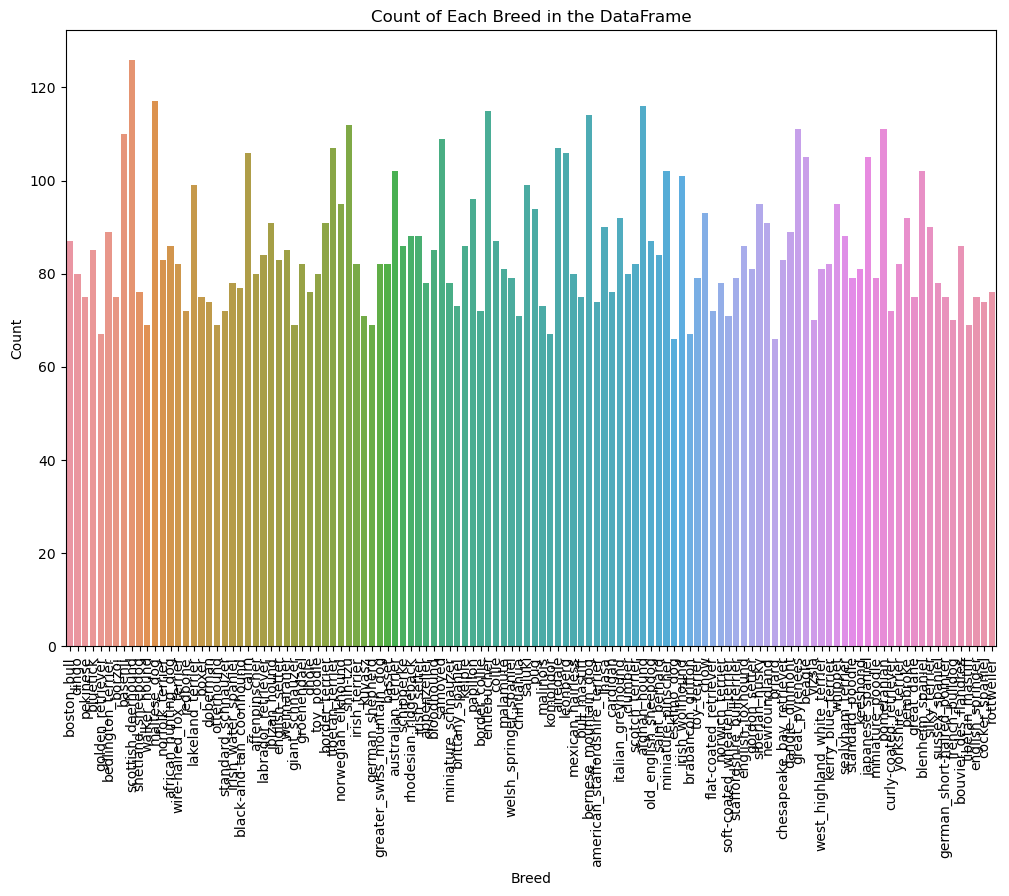

In [14]:
# Number of breeds
n_breeds = labels_breed['breed'].nunique()
print(f"There are {n_breeds} unique dog breeds.")

# Create a seaborn histogram
plt.figure(figsize=(12, 8))  # Optional: Adjust the figure size if needed
sns.countplot(data=labels_breed, x='breed')
plt.xticks(rotation=90)
plt.xlabel('Breed')
plt.ylabel('Count')
plt.title('Count of Each Breed in the DataFrame')
plt.show()

In [15]:
# Lets encode the breeds first
label_encoder = LabelEncoder()
# Fit and transform the breed labels
labels_breed['breed_encoded'] = label_encoder.fit_transform(labels_breed['breed'])
print(f"Lets see some of the encoded labels:\n{labels_breed}")

# Secondly lets one-hot-encode the labels
labels_encoded = to_categorical(labels_breed['breed_encoded'])
print("Some of the encoded labels: \n", labels_encoded)

Lets see some of the encoded labels:
                          breed  breed_encoded
0                   boston_bull             19
1                         dingo             37
2                      pekinese             85
3                      bluetick             15
4              golden_retriever             49
...                         ...            ...
10217                    borzoi             18
10218            dandie_dinmont             35
10219                  airedale              3
10220        miniature_pinscher             75
10221  chesapeake_bay_retriever             28

[10222 rows x 2 columns]
Some of the encoded labels: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Lets analyze the training and test dataset

###### Train set

In [18]:
# Lets see training dataset info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Columns: 49152 entries, 0 to 49151
dtypes: int64(49152)
memory usage: 3.7 GB


In [19]:
# Lets some training images information
train_df.head() # NOTE, it has 49151 because we have 3 RGB channels = 128 * 128 *3

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,85,107,67,88,108,71,80,100,66,81,...,44,96,122,39,104,128,53,92,116,47
1,86,83,82,93,96,93,49,58,53,44,...,107,109,102,81,110,95,72,115,90,84
2,105,104,99,110,109,104,110,109,104,113,...,109,115,114,110,114,113,109,110,109,104
3,156,99,53,177,133,80,192,155,91,157,...,91,118,42,42,141,76,46,202,150,92
4,142,135,144,143,135,144,158,150,159,151,...,148,158,149,158,161,147,156,145,129,140


In [20]:
# Lets see the train_df shape
n_images, n_features = train_df.shape
print(f"In the training dataframe there are {n_images} images having {n_features} features.")
print(f"This {n_features} features result by images with size {target_size} by 3, the number of channels.")

In the training dataframe there are 10222 images having 49152 features.
This 49152 features result by images with size (128, 128) by 3, the number of channels.


In [21]:
# Function to see pixel intensity distribution
def plot_pixel_intensity_histograms(pixel_values, labels, n_images):
    fig, axs = plt.subplots(1, n_images, figsize=(30, 10))
    
    # Ensure axs is always iterable, even for n_images = 1
    if n_images == 1:
        axs = [axs]
    
    for i in range(n_images):
        sns.histplot(pixel_values[:, i], bins=256, kde=True, ax=axs[i])
        axs[i].set_title(f'Pixel Intensity Histogram for Image {i+1} - Label: {labels[i]}')
        axs[i].set_xlabel('Pixel Intensity')
        axs[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


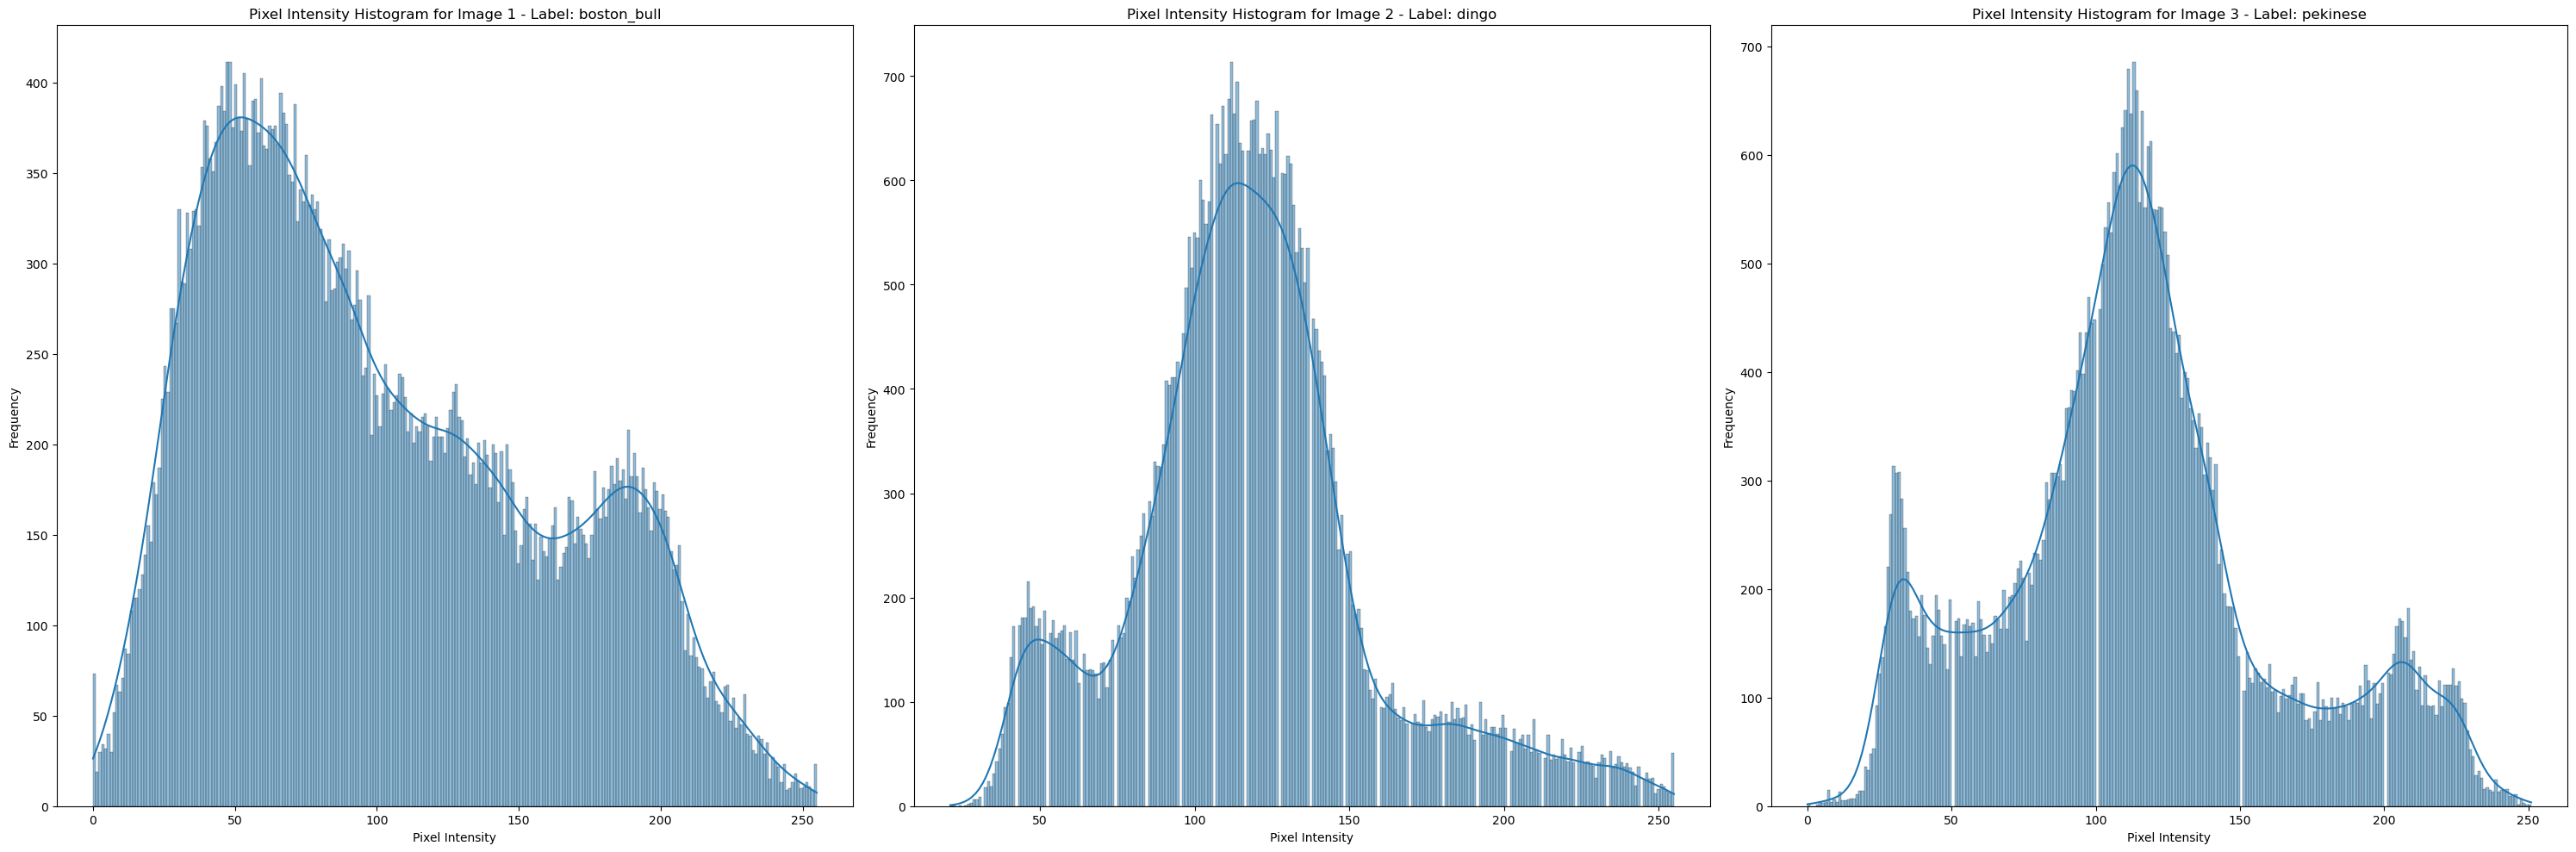

In [22]:
# Lets see if there is any noise
n_images = 3 # Lets define number of histograms we want to see
selected_images = train_df.iloc[:n_images].values # Extract the pixel values for the selected images so its faster
selected_images = selected_images.T # Transpose the selected images to get the pixel values in the correct format
selected_labels = labels.iloc[:n_images, 1]

# Lets plot
plot_pixel_intensity_histograms(selected_images, selected_labels, n_images)

###### Test

In [24]:
# Lets see testing dataset info
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10357 entries, 0 to 10356
Columns: 49152 entries, 0 to 49151
dtypes: int64(49152)
memory usage: 3.8 GB


In [25]:
# Lets some testing images information
test_df.head() # NOTE, it has 49151 because we have 3 RGB channels = 128 * 128 *3

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,12,26,11,10,23,7,9,23,4,15,...,10,96,108,34,99,109,33,87,103,25
1,0,19,25,2,21,27,3,22,28,3,...,6,4,8,7,4,8,7,4,8,7
2,186,172,86,183,173,59,191,178,82,191,...,149,215,170,145,215,167,138,213,163,132
3,94,106,82,88,107,83,84,106,76,95,...,24,124,88,9,122,85,15,128,81,21
4,126,114,90,127,116,93,129,121,99,126,...,158,161,163,153,165,164,159,165,160,158


In [26]:
# Lets see the test_df shape
n_images_test, n_features_test = test_df.shape
print(f"In training test we have {n_images_test} images.")
print(f"The number of feautes is the same because it went from the same processing process as the training.")

In training test we have 10357 images.
The number of feautes is the same because it went from the same processing process as the training.


###### Lets process both datasets: normalize and check for Inf and NaN

In [28]:
# Lets normalize the values of train data
train_df = train_df / 255
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0.333333,0.419608,0.262745,0.345098,0.423529,0.278431,0.313725,0.392157,0.258824,0.317647,...,0.172549,0.376471,0.478431,0.152941,0.407843,0.501961,0.207843,0.360784,0.454902,0.184314
1,0.337255,0.325490,0.321569,0.364706,0.376471,0.364706,0.192157,0.227451,0.207843,0.172549,...,0.419608,0.427451,0.400000,0.317647,0.431373,0.372549,0.282353,0.450980,0.352941,0.329412
2,0.411765,0.407843,0.388235,0.431373,0.427451,0.407843,0.431373,0.427451,0.407843,0.443137,...,0.427451,0.450980,0.447059,0.431373,0.447059,0.443137,0.427451,0.431373,0.427451,0.407843
3,0.611765,0.388235,0.207843,0.694118,0.521569,0.313725,0.752941,0.607843,0.356863,0.615686,...,0.356863,0.462745,0.164706,0.164706,0.552941,0.298039,0.180392,0.792157,0.588235,0.360784
4,0.556863,0.529412,0.564706,0.560784,0.529412,0.564706,0.619608,0.588235,0.623529,0.592157,...,0.580392,0.619608,0.584314,0.619608,0.631373,0.576471,0.611765,0.568627,0.505882,0.549020


In [29]:
# Lets normalize the values of test data
test_df = test_df / 255
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0.047059,0.101961,0.043137,0.039216,0.090196,0.027451,0.035294,0.090196,0.015686,0.058824,...,0.039216,0.376471,0.423529,0.133333,0.388235,0.427451,0.129412,0.341176,0.403922,0.098039
1,0.000000,0.074510,0.098039,0.007843,0.082353,0.105882,0.011765,0.086275,0.109804,0.011765,...,0.023529,0.015686,0.031373,0.027451,0.015686,0.031373,0.027451,0.015686,0.031373,0.027451
2,0.729412,0.674510,0.337255,0.717647,0.678431,0.231373,0.749020,0.698039,0.321569,0.749020,...,0.584314,0.843137,0.666667,0.568627,0.843137,0.654902,0.541176,0.835294,0.639216,0.517647
3,0.368627,0.415686,0.321569,0.345098,0.419608,0.325490,0.329412,0.415686,0.298039,0.372549,...,0.094118,0.486275,0.345098,0.035294,0.478431,0.333333,0.058824,0.501961,0.317647,0.082353
4,0.494118,0.447059,0.352941,0.498039,0.454902,0.364706,0.505882,0.474510,0.388235,0.494118,...,0.619608,0.631373,0.639216,0.600000,0.647059,0.643137,0.623529,0.647059,0.627451,0.619608


In [30]:
# lets check now for Nan and Inf values on training test
train_df_contains_nan = train_df.isna().any().any()
train_df_contains_inf = (train_df == float('inf')).any().any()
train_df_contains_NegInf = (train_df == -float('inf')).any().any()

print("Are there Inf and/or NaN values in train_df?")
print("Training dataframe Contains NaN values:", train_df_contains_nan)
print("Training dataframe Contains Inf values:", train_df_contains_inf)
print("Training dataframe Contains -Inf values:", train_df_contains_NegInf)

Are there Inf and/or NaN values in train_df?
Training dataframe Contains NaN values: False
Training dataframe Contains Inf values: False
Training dataframe Contains -Inf values: False


In [31]:
# lets check now for Nan and Inf values on testing test
test_df_contains_nan = test_df.isna().any().any()
test_df_contains_inf = (test_df == float('inf')).any().any()
test_df_contains_NegInf = (test_df == -float('inf')).any().any()

print("Are there Inf and/or NaN values in test_df?")
print("Testing dataframe Contains NaN values:", test_df_contains_nan)
print("Testing dataframe Contains Inf values:", test_df_contains_inf)
print("Testing dataframe Contains -Inf values:", test_df_contains_NegInf)

Are there Inf and/or NaN values in test_df?
Testing dataframe Contains NaN values: False
Testing dataframe Contains Inf values: False
Testing dataframe Contains -Inf values: False


In [32]:
# Lets make a function to convert array to
def dataframe_to_NpImages(df, image_size, num_channels):

    # Initialize an empty list to store reshaped images
    images = []
    
    # Iterate over each row (image) in the dataframe
    for _, row in df.iterrows():
        # Convert the row to a numpy array
        image_flat = row.values
        
        # Reshape the flat image into the desired dimensions
        image_rgb = image_flat.reshape((image_size[0], image_size[1], num_channels))
        
        # Append to the list of images
        images.append(image_rgb)
    
    # Convert the list of images to a numpy array
    images_array = np.array(images)
    
    return images_array

In [33]:
# Lets convert now the train_df to images to use has input of our model
training_images = []
num_channels = 3 # Our images are RGB
# Convert
training_images = dataframe_to_NpImages(train_df, target_size, num_channels)

print("Shape of our images after processing and ready to use them in model: ",training_images.shape)
print("Lets print 1st image:\n ", training_images[0])

Shape of our images after processing and ready to use them in model:  (10222, 128, 128, 3)
Lets print 1st image:
  [[[0.33333333 0.41960784 0.2627451 ]
  [0.34509804 0.42352941 0.27843137]
  [0.31372549 0.39215686 0.25882353]
  ...
  [0.33333333 0.39215686 0.28235294]
  [0.29411765 0.35294118 0.23529412]
  [0.24705882 0.30980392 0.17254902]]

 [[0.34509804 0.42352941 0.27058824]
  [0.36862745 0.44313725 0.30196078]
  [0.30196078 0.37254902 0.23921569]
  ...
  [0.3254902  0.35686275 0.27058824]
  [0.33333333 0.36078431 0.2745098 ]
  [0.27843137 0.30980392 0.21176471]]

 [[0.35686275 0.42352941 0.27843137]
  [0.31372549 0.37647059 0.24313725]
  [0.29803922 0.36470588 0.23529412]
  ...
  [0.43137255 0.42352941 0.37647059]
  [0.47843137 0.4745098  0.42352941]
  [0.2745098  0.26666667 0.21568627]]

 ...

 [[0.39215686 0.4627451  0.28627451]
  [0.42745098 0.49803922 0.3254902 ]
  [0.41960784 0.49411765 0.31764706]
  ...
  [0.44705882 0.5254902  0.23137255]
  [0.37647059 0.45490196 0.16078431

In [34]:
# Lets convert now the test_df to images to predict
testing_images = []
# Convert
testing_images = dataframe_to_NpImages(test_df, target_size, num_channels)

print("Shape of our images after processing and ready to predict: ",testing_images.shape)
print("Lets print 1st image:\n ", testing_images[0])

Shape of our images after processing and ready to predict:  (10357, 128, 128, 3)
Lets print 1st image:
  [[[0.04705882 0.10196078 0.04313725]
  [0.03921569 0.09019608 0.02745098]
  [0.03529412 0.09019608 0.01568627]
  ...
  [0.1254902  0.20392157 0.01960784]
  [0.09803922 0.2        0.01960784]
  [0.15686275 0.2627451  0.04313725]]

 [[0.04313725 0.09411765 0.03137255]
  [0.0745098  0.1254902  0.05882353]
  [0.03921569 0.09411765 0.01176471]
  ...
  [0.14509804 0.21176471 0.05098039]
  [0.07843137 0.16862745 0.02745098]
  [0.15686275 0.26666667 0.05098039]]

 [[0.02745098 0.07058824 0.00784314]
  [0.04705882 0.09411765 0.02352941]
  [0.0745098  0.1254902  0.03529412]
  ...
  [0.2        0.26666667 0.06666667]
  [0.1372549  0.21960784 0.04313725]
  [0.12156863 0.22352941 0.00784314]]

 ...

 [[0.38431373 0.40784314 0.12941176]
  [0.32156863 0.38039216 0.10196078]
  [0.23529412 0.24705882 0.05882353]
  ...
  [0.38823529 0.38431373 0.14117647]
  [0.36078431 0.36862745 0.1254902 ]
  [0.341

# Modeling

In [36]:
# Lets just check the shape of images and labels to see if they are in accordance
print("Training images shape: ", training_images.shape)
print("Encoded Labels shape: ", labels_encoded.shape)
#Split training and validation set. Lets make a 80% for training and 20% for validation
X_train, X_val, Y_train, Y_val = train_test_split(training_images, labels_encoded, test_size=0.2)

print("\nShape of X_train = ", X_train.shape)
print("Shape of Y_train = ", Y_train.shape)

print("\nShape of X_val = ", X_val.shape)
print("Shape of Y_val = ", Y_val.shape)

Training images shape:  (10222, 128, 128, 3)
Encoded Labels shape:  (10222, 120)

Shape of X_train =  (8177, 128, 128, 3)
Shape of Y_train =  (8177, 120)

Shape of X_val =  (2045, 128, 128, 3)
Shape of Y_val =  (2045, 120)


In [37]:
# Lets define a model
model = Sequential([
    # Lets define the Input
    Input(shape=(target_size[0], target_size[1], num_channels)),
    
    # Lets Define the first block
    Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)),
    BatchNormalization(),
    Activation('relu'),
    
    # Lets Define the Second block
    Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Lets Define the third block
    Conv2D(128, kernel_size=(3, 3), padding='same', strides=(1, 1)),
    BatchNormalization(),
    Activation('relu'),
    
    # Lets Define the fourth block
    Conv2D(128, kernel_size=(3, 3), padding='same', strides=(1, 1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Lets Define the fifth block
    Conv2D(256, kernel_size=(3, 3), padding='same', strides=(1, 1)),
    BatchNormalization(),
    Activation('relu'),
    
    # Lets Define the sixth block
    Conv2D(256, kernel_size=(3, 3), padding='same', strides=(1, 1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Now lets make it from 2D to 1D
    Flatten(),

    # First block in 1D
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Second block in 1D
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Define the final output
    Dense(n_breeds, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 256)    │             

 Total params: 35,032,248 (133.64 MB)

 Trainable params: 35,028,408 (133.62 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [38]:
# Define some variables for training
n_epoches = 25
batch_size = 32

In [39]:
# Check if a pre-trained model exists
if os.path.exists('CNN_DogBreedIdentification_Kaggle.keras'):
    # Load the pre-trained model
    model = load_model('CNN_DogBreedIdentification_Kaggle.keras')
    print("Pre-trained model loaded.")

    # Load the training history
    if os.path.exists('training_history.json'):
        with open('training_history.json', 'r') as f:
            history_loaded = json.load(f)
            history = None
    else:
        history_loaded = None

else:
    # Lets compile
    model.compile(
        optimizer = 'adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Lets fit the model
    history =  model.fit(
        X_train,
        Y_train,
        validation_data=(X_val, Y_val),
        epochs = n_epoches,
        batch_size= batch_size,
        #callbacks = [ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00000001), 
        #             EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Save the trained model (if training new model)
    model.save('CNN_DogBreedIdentification_Kaggle.keras')
    print("CNN trained and saved.")

    # Save the history
    with open('training_history.json', 'w') as f:
        json.dump(history.history, f)

Epoch 1/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 801s 3s/step - accuracy: 0.0079 - loss: 5.4142 - val_accuracy: 0.0112 - val_loss: 4.8120
Epoch 2/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 788s 3s/step - accuracy: 0.0086 - loss: 5.0792 - val_accuracy: 0.0068 - val_loss: 4.8117
Epoch 3/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 787s 3s/step - accuracy: 0.0115 - loss: 4.9841 - val_accuracy: 0.0132 - val_loss: 4.9875
Epoch 4/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 783s 3s/step - accuracy: 0.0095 - loss: 4.9329 - val_accuracy: 0.0098 - val_loss: 5.0087
Epoch 5/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 780s 3s/step - accuracy: 0.0138 - loss: 4.8814 - val_accuracy: 0.0088 - val_loss: 4.8604
Epoch 6/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 781s 3s/step - accuracy: 0.0148 - loss: 4.8407 - val_accuracy: 0.0088 - val_loss: 4.8652
Epoch 7/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 780s 3s/step - accuracy: 0.0148 - loss: 4.8115 - val_accuracy: 0.0108 - val_loss: 4.8612
Epoch 8/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 778s 3s/step - accuracy: 0.0171 - loss: 4.7823 - val_accu

# Evaluate

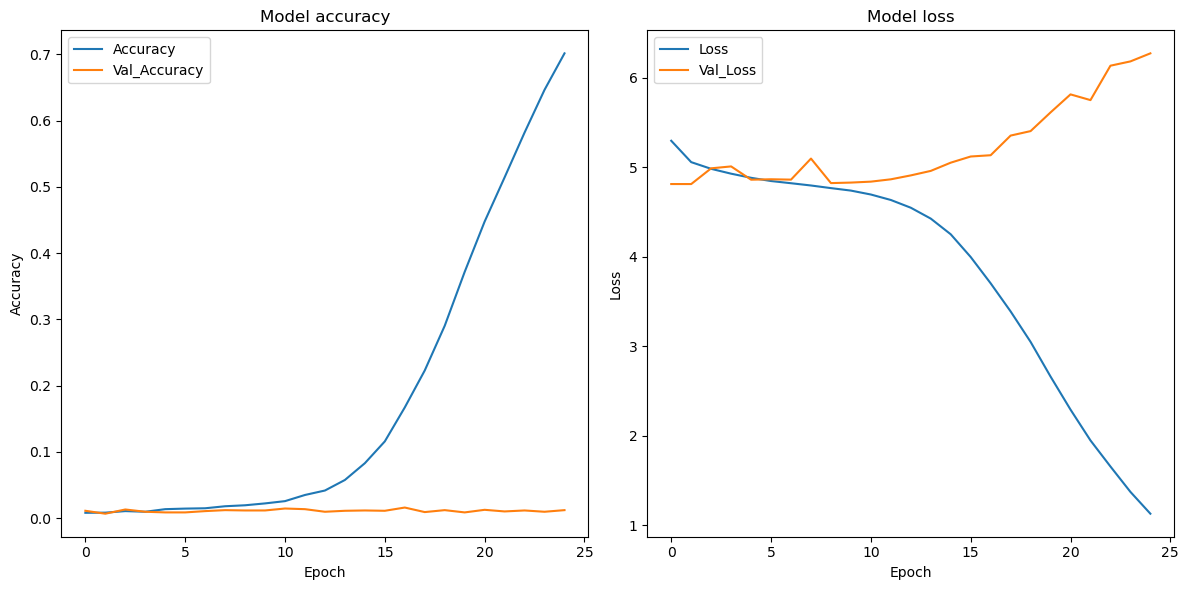

In [41]:
if history:
    # Plot the training and validation accuracy and loss
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(history.history['accuracy'], label='train accuracy')
    ax[0].plot(history.history['val_accuracy'], label='val accuracy')
    ax[0].set_title('Model accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['Accuracy', 'Val_Accuracy'])
    
    ax[1].plot(history.history['loss'], label='train loss')
    ax[1].plot(history.history['val_loss'], label='val loss')
    ax[1].set_title('Model loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Loss', 'Val_Loss'])
    
    plt.tight_layout()
    plt.show()

else:
    # Plot the training and validation accuracy and loss
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(history_loaded['accuracy'], label='train accuracy')
    ax[0].plot(history_loaded['val_accuracy'], label='val accuracy')
    ax[0].set_title('Model accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['Accuracy', 'Val_Accuracy'])
    
    ax[1].plot(history_loaded['loss'], label='train loss')
    ax[1].plot(history_loaded['val_loss'], label='val loss')
    ax[1].set_title('Model loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Loss', 'Val_Loss'])
    
    plt.tight_layout()
    plt.show()

In [43]:
# Lets make a prediction to see if the output is as expected
pred = model.predict(X_val)

print("Shape of the prediction: ", pred.shape)
print("Some examples: ", pred)

64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 497ms/step
Shape of the prediction:  (2045, 120)
Some examples:  [[6.9177977e-04 1.3647028e-03 1.5681618e-04 ... 8.4718587e-03
  7.5536012e-04 4.2913561e-03]
 [2.3502221e-03 7.4903265e-04 8.3148098e-03 ... 9.4921212e-04
  1.5470766e-02 2.5826031e-03]
 [1.3709045e-03 1.3725783e-03 7.5442535e-05 ... 1.5481103e-03
  1.2500155e-03 2.8046430e-04]
 ...
 [3.3622659e-05 1.2779359e-02 3.6556026e-04 ... 5.3342700e-04
  2.1096499e-04 6.6041859e-04]
 [1.3939133e-03 3.2976561e-04 4.6313871e-03 ... 5.3522311e-04
  1.5309718e-02 9.9983870e-04]
 [7.1604401e-03 2.0194503e-03 1.5852811e-02 ... 1.3112597e-02
  4.2022550e-03 1.6639492e-02]]
